In [1]:
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler,StableDiffusionPipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import tqdm
import PIL
from matplotlib import pyplot as plt

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
prompt = ''

device = 'cuda'
seed = 2024
noisy_sample = torch.randn(
    1, 4, 64, 64
).to(device)
# noisy_sample = torch.randn(
#     1, 4, 512, 512
# ).to('cuda:0')
# noisy_sample = torch.randn(
#     1, 4, 56, 56
# ).to('cuda:0')
# prompt.to(device)

In [3]:
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

## 填充腐蚀区域（前提要有members的mask）

### 1.基于members的mask，生成腐蚀（腐蚀形状：多边形；腐蚀数量：自定义，一定范围自动确定；腐蚀尺度：一定范围随机生成）

In [4]:
def times(x, y):
    return x * y
type(times)

function

### ！！形状和形状的数量可控，损伤的类型可控（以腐蚀为例）

In [9]:
###################################################################################
# img_name = 'IMG_20230715_152221'

# img_name = 'tt_1206'
# img_name = 'tt_1183'
img_name = 'tt_180'
# org_img_dir = f'/home/ubunto/Project/konglx/generate/ControlNet-v1-1-nightly/training/corrosion_and_crack/corrosion/JPEGImages/{img_name}.jpg'
org_img_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_members/SBCIV_dataset/512_size/JPEGImages/{img_name}.jpg'
org_img_pil = load_image(org_img_dir)
# print(org_img_pil.mode)
# mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_members/SBCIV_dataset/512_size/SegmentationClass/defect/{img_name}.png'
mask_corrosion_dir = None
# mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/members/conditioning_images/{img_name}.png'
mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_members/SBCIV_dataset/512_size/SegmentationClass/element/{img_name}.png'

# mask_members_dir = None
# mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_members/SBCIV_dataset/512_size/depth/{img_name}.png'

mask_org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_members/SBCIV_dataset/512_size/JPEGImages/{img_name}.jpg'
# mask_org_dir = None
###################################################################################


In [10]:
import numpy as np
import random
from PIL import Image, ImageDraw

mask_members_np_demo = np.array(Image.open(mask_members_dir))
print(mask_members_np_demo.shape)

random.seed(4)

########### 定义颜色转换方法 ##############
import imgviz

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil


(512, 512)


In [11]:
def paste_pil_a_to_b(a_pil, b_pil):
    a_pil_rgba = a_pil.convert('RGBA')
    b_pil_rgba = b_pil.convert('RGBA')
    a_b_pil_rgba = Image.blend(a_pil_rgba, b_pil_rgba, 0.5)
    a_b_pil_rgb = a_b_pil_rgba.convert('RGB')
    return a_b_pil_rgb

# gen_corrosion_with_org_img = paste_pil_a_to_b(org_img_pil, mask_only_corrosion_final_pil)
# gen_corrosion_with_org_img

## 载入图片

mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is not None


100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


RGB
RGB


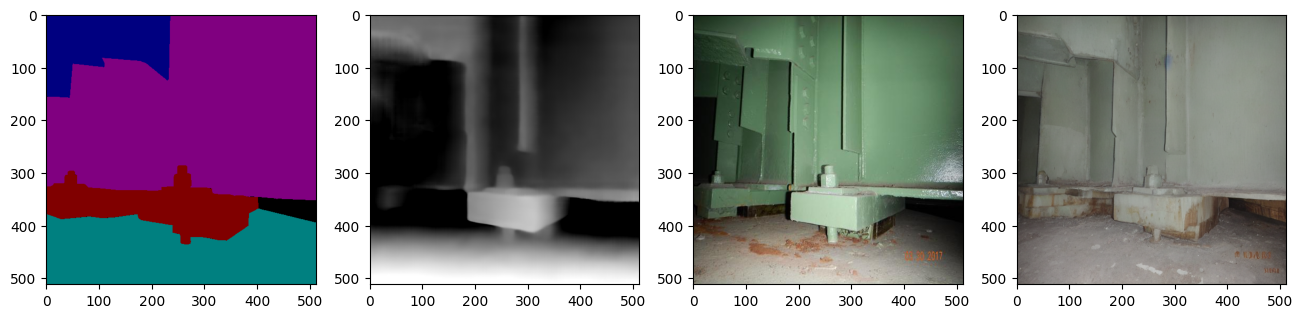

In [12]:
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'
# control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-256_w-256_2024-07-12_09:10:44_seeds-2024/checkpoint-5700/controlnet'
control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-512_w-512_2024-07-19_11:32:25_seeds-2024/checkpoint-5700/controlnet'

control_members_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_members_inpainting_h-256_w-256_2024-07-12_14:52:34_seeds-2024/checkpoint-3800/controlnet'
# control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet'

control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_inpainting_h-512_w-512_2024-07-19_21:57:45_seeds-2024/checkpoint-5700/controlnet'
# control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_no_corrosion_inpainting_h-512_w-512_2024-07-20_08:28:10_seeds-2024/checkpoint-2000/controlnet'
# control_org_trained_dir = None
# controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth]


# 有members，无corrosion，无depth
if mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is None:
    mask_members_pil = load_image(mask_members_dir)
    validation_image = mask_members_pil
    control_members_dir = control_members_trained_dir
    print('mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is None')
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=controlnet_members).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
    # Image.show(image)
# 无members，有corrosion，无depth
elif mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is None:
    control_corrosion_dir = control_corrosion_trained_dir
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    validation_image = mask_corrosion_pil
    print('mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=controlnet_corrosion).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
# 无members，无corrosion，有depth  
elif mask_members_dir is  None and mask_corrosion_dir is None and mask_depth_dir is not None:
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_depth_pil = load_image(mask_depth_dir)
    validation_image = mask_depth_pil
    print('mask_members_dir is  None and mask_corrosion_dir is None and mask_depth_dir is not None')
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=controlnet_depth).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_depth_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
# 有members，有corrosion，无depth
elif mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is None:
    control_corrosion_dir = control_corrosion_trained_dir
    control_members_dir = control_members_trained_dir
    mask_members_pil = load_image(mask_members_dir)
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    validation_image = [mask_corrosion_pil, mask_members_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion, controlnet_members]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    print(mask_corrosion_pil.mode)
    plt.subplot(142)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()
# 无members，有corrosion，有depth 
elif mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is not None:
    control_corrosion_dir = control_corrosion_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_depth_pil = load_image(mask_depth_dir)
    mask_corrosion_pil = load_image(mask_corrosion_dir)
    validation_image = [mask_corrosion_pil, mask_depth_pil]
    print('mask_members_dir is  None and mask_corrosion_dir is not None and mask_depth_dir is not None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion, controlnet_depth]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    print(mask_corrosion_pil.mode)
    plt.subplot(142)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()
# 有members，无corrosion，有depth
elif mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is not None:
    control_members_dir = control_members_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    mask_depth_pil = load_image(mask_depth_dir)
    mask_members_pil = load_image(mask_members_dir)
    validation_image = [mask_members_pil, mask_depth_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is None and mask_depth_dir is not None')
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_members, controlnet_depth]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                    ).images[0]
    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(142)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()
# 有members，有corrosion，有depth,无原图
elif mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None and mask_org_dir is None:
    
    # controlnet_conditioning_scale_list=[1.0,1.0,1.0]
    controlnet_conditioning_scale_list=0.1
    
    control_corrosion_dir = control_corrosion_trained_dir
    control_members_dir = control_members_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    # mask_corrosion_pil = load_image(mask_corrosion_dir)
    mask_corrosion_pil = mask_only_corrosion_final_pil
    mask_members_pil = load_image(mask_members_dir)
    mask_depth_pil = load_image(mask_depth_dir)
    validation_image = [mask_corrosion_pil, mask_members_pil, mask_depth_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth], 
                                                                 controlnet_conditioning_scale=controlnet_conditioning_scale_list).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, iter_times=5
                    ).images[0]
    plt.figure(figsize=(20, 5))
    plt.subplot(151)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(152)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(153)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(154)
    plt.imshow(org_img_pil)
    plt.subplot(155)
    plt.imshow(image)
    plt.show()
    
# 有members，有corrosion，有depth,有原图
elif mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None and mask_org_dir is not None:
    controlnet_conditioning_scale_list=[3.0,1.0,1.0, 1.0]
    # controlnet_conditioning_scale_list = 0.5
    
    control_corrosion_dir = control_corrosion_trained_dir
    control_members_dir = control_members_trained_dir
    # control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
    control_depth_dir = control_depth_trained_dir
    
    control_org_dir = control_org_trained_dir
    
    # mask_corrosion_pil = load_image(mask_corrosion_dir)
    mask_corrosion_pil = load_image(mask_only_corrosion_final_pil)
    print(mask_corrosion_pil.mode)
    mask_members_pil = load_image(mask_members_dir)
    mask_depth_pil = load_image(mask_depth_dir)
    mask_org_pil = load_image(mask_org_dir)
    
    validation_image = [mask_corrosion_pil, mask_members_pil, mask_depth_pil, mask_org_pil]
    print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None,and mask_org_dir is not None')
    controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
    controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
    controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
    controlnet_org = ControlNetModel.from_pretrained(control_org_dir)
    
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth, controlnet_org]).to(device)
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, iter_times=5, controlnet_conditioning_scale=controlnet_conditioning_scale_list, guidance_scale=10
                    ).images[0]
    plt.figure(figsize=(20, 5))
    plt.subplot(151)
    plt.imshow(mask_corrosion_pil)
    print(mask_corrosion_pil.mode)
    plt.subplot(152)
    plt.imshow(mask_members_pil)
    print(mask_members_pil.mode)
    plt.subplot(153)
    plt.imshow(mask_depth_pil)
    print(mask_depth_pil.mode)
    plt.subplot(154)
    plt.imshow(org_img_pil)
    plt.subplot(155)
    plt.imshow(image)
    plt.show()
    
# 无members，无corrosion，无depth
else:
    print('Input nothing')
# image

In [ ]:
print(2 / 3 < 0 or (2 + 1) / 3 > 1)
1.0 - float(2 / 3 < 0 or (2 + 1) / 3 > 1)


In [ ]:
mask_corrosion_np = np.array(mask_corrosion_pil)
mask_corrosion_np.min(), mask_corrosion_np.max(), mask_corrosion_np.shape

In [ ]:
# if mask_members_dir is not None and mask_corrosion_dir is None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_members_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
#     # Image.show(image)
    
# elif mask_members_dir is  None and mask_corrosion_dir is not None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
# else:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(131)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(132)
#     plt.imshow(mask_members_pil)
#     plt.subplot(133)
#     plt.imshow(image)
#     plt.show()

## PNDM

In [ ]:
# PNDMScheduler
generator = torch.Generator(device=device).manual_seed(seed)
image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## DDPM

In [ ]:
# DDPMScheduler
from diffusers import DDPMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddpm = DDPMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

# print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddpm
# print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

In [ ]:
if mask_members_dir is not None and mask_corrosion_dir is None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_members_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
    # Image.show(image)
    
elif mask_members_dir is  None and mask_corrosion_dir is not None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
else:

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(142)
    plt.imshow(mask_members_pil)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()

## DDIM

In [ ]:
# DDIMScheduler
from diffusers import DDIMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddim = DDIMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

# print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddim
# print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## PNDM

In [ ]:
# PNDMScheduler
from diffusers import PNDMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_pndm = PNDMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

# print(pipeline.scheduler)
pipeline.scheduler = scheduler_pndm
# print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image